In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import os

# Import functions from your preprocessing.py
from preprocessing import (
    Config,
    _read_wav,
    _resample,
    _apply_bandpass,
    _apply_notch50,
    segment_signal,
    zscore_norm,
)

In [4]:
wav_path = "Dataset/Mixed/_Users_nro_emg3_AppData_Local_Temp_u5ic_7.wav"   # ⬅️ ändere das hier auf eine echte Datei
output_dir = "Preprocessed/viz_notebook"
os.makedirs(output_dir, exist_ok=True)

# Preprocessing-Konfiguration
cfg = Config(
    input_dir=".",
    output_dir=output_dir,
    target_sr=11025,
    window_sec=1.0,
    hop_sec=0.5,
    apply_bandpass=True,
    bandpass=(20.0, 4500.0),
    filter_order=4,
    apply_notch=True,
    notch_freq=50.0,
    notch_q=30.0,
    augment=False
)

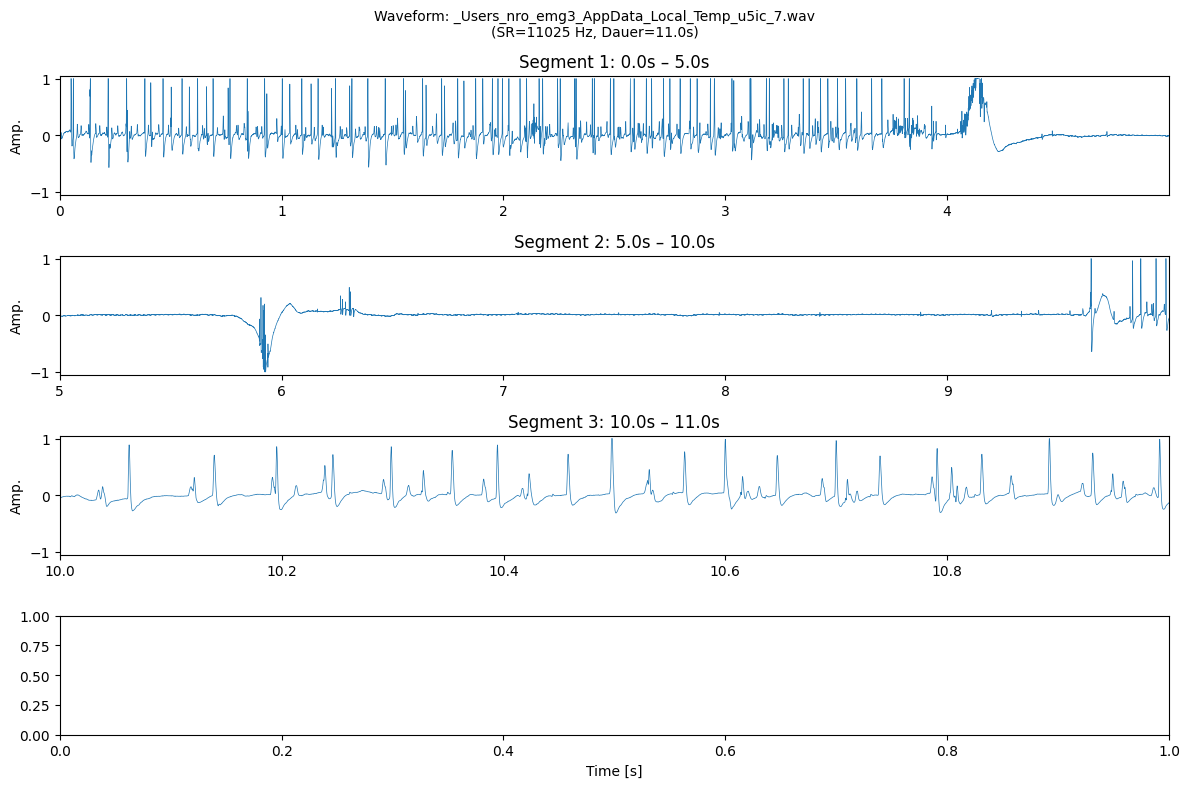

In [13]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pathlib import Path

# === Parameter ===
wav_path = "Dataset/Mixed/_Users_nro_emg3_AppData_Local_Temp_u5ic_7.wav"      # deine Datei
seconds_per_row = 5             # wie viele Sekunden pro Zeile anzeigen
n_rows = 4                      # wie viele Zeilen/Subplots
downsample_factor = 2           # zur Darstellung (nicht fürs Signal selbst)

# === Datei laden ===
y, sr = sf.read(wav_path)
if y.ndim > 1:
    y = y.mean(axis=1)  # Stereo → Mono

# optional normalisieren
if np.issubdtype(y.dtype, np.integer):
    y = y.astype(np.float32) / np.iinfo(np.int16).max

# Zeitvektor
t = np.arange(len(y)) / sr
total_duration = len(y) / sr
samples_per_row = int(seconds_per_row * sr)

# === Plot ===
fig, axes = plt.subplots(n_rows, 1, figsize=(12, n_rows*2), sharex=False)

for i in range(n_rows):
    start = i * samples_per_row
    end = min((i+1) * samples_per_row, len(y))
    if start >= len(y):
        break
    ax = axes[i]
    ax.plot(t[start:end:downsample_factor], y[start:end:downsample_factor], lw=0.5)
    ax.set_xlim(t[start], t[end-1])
    ax.set_ylim(-1.05, 1.05)
    ax.set_ylabel("Amp.")
    ax.set_title(f"Segment {i+1}: {t[start]:.1f}s – {t[end-1]:.1f}s")

axes[-1].set_xlabel("Time [s]")
fig.suptitle(f"Waveform: {Path(wav_path).name}\n(SR={sr} Hz, Dauer={total_duration:.1f}s)", fontsize=10)
plt.tight_layout()
plt.show()


In [5]:
y_raw, sr_raw = _read_wav(wav_path)
y_rs = _resample(y_raw, sr_raw, cfg.target_sr)

print(f"Raw SR: {sr_raw}, Resampled SR: {cfg.target_sr}, Länge: {len(y_rs)/cfg.target_sr:.2f}s")

Raw SR: 11025, Resampled SR: 11025, Länge: 11.00s


In [6]:
if cfg.apply_bandpass:
    y_bp = _apply_bandpass(y_rs, cfg.target_sr, cfg.bandpass, cfg.filter_order)
else:
    y_bp = y_rs.copy()

if cfg.apply_notch:
    y_filt = _apply_notch50(y_bp, cfg.target_sr, cfg.notch_freq, cfg.notch_q)
else:
    y_filt = y_bp.copy()

In [7]:
segs = segment_signal(y_filt, cfg.target_sr, cfg.window_sec, cfg.hop_sec)
segs_norm = np.stack([zscore_norm(s) for s in segs]) if len(segs) else None
print(f"Anzahl Segmente: {len(segs)} | Fensterlänge: {cfg.window_sec}s | Hop: {cfg.hop_sec}s")

Anzahl Segmente: 21 | Fensterlänge: 1.0s | Hop: 0.5s


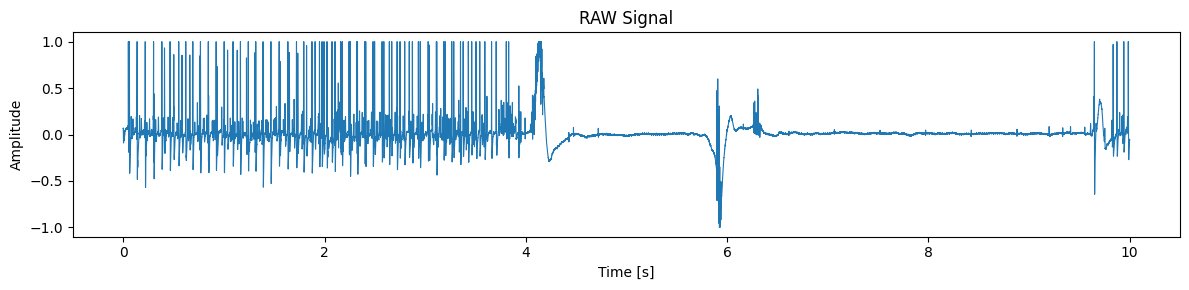

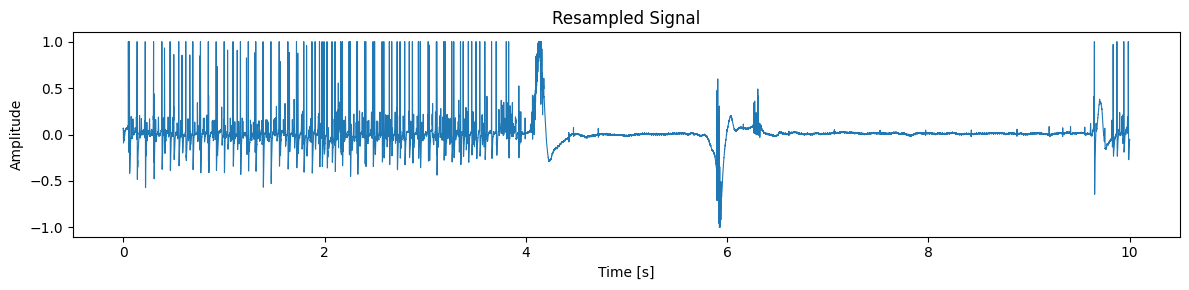

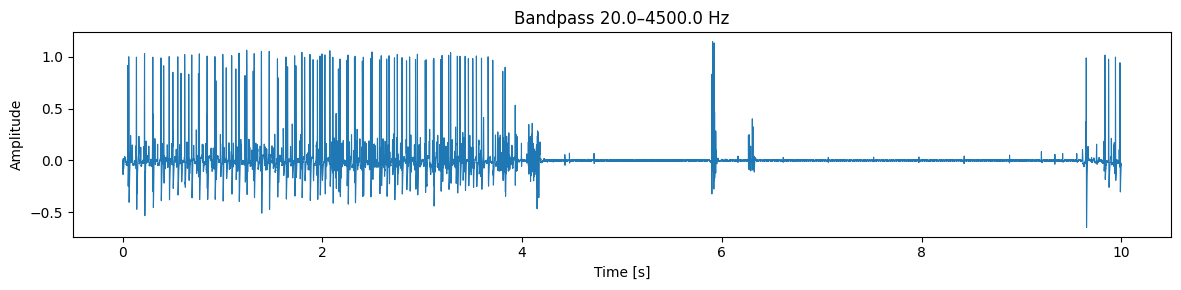

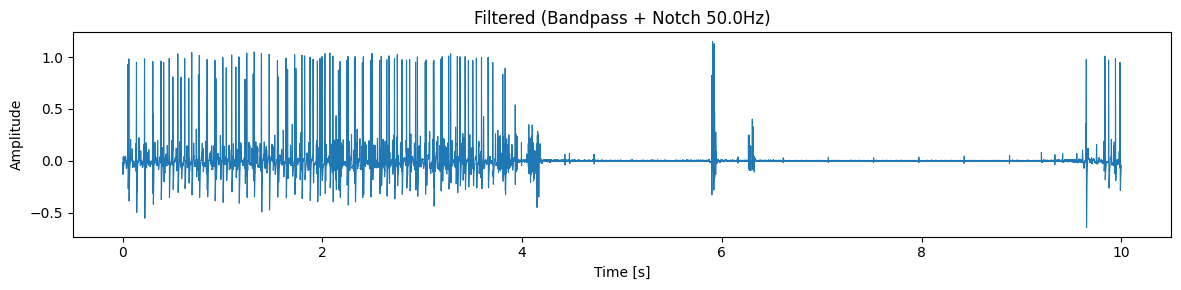

In [12]:
def plot_signal(y, sr, title, seconds=10):
    t = np.arange(len(y)) / sr
    if seconds:
        y, t = y[: int(seconds*sr)], t[: int(seconds*sr)]
    plt.figure(figsize=(12,3))
    plt.plot(t, y, linewidth=0.8)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_signal(y_raw, sr_raw, "RAW Signal")
plot_signal(y_rs, cfg.target_sr, "Resampled Signal")
plot_signal(y_bp, cfg.target_sr, f"Bandpass {cfg.bandpass[0]}–{cfg.bandpass[1]} Hz")
plot_signal(y_filt, cfg.target_sr, f"Filtered (Bandpass + Notch {cfg.notch_freq}Hz)")

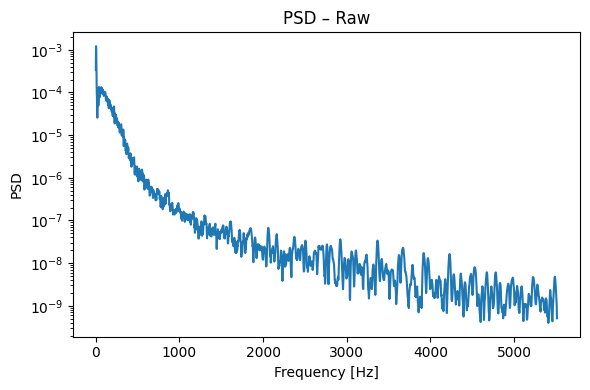

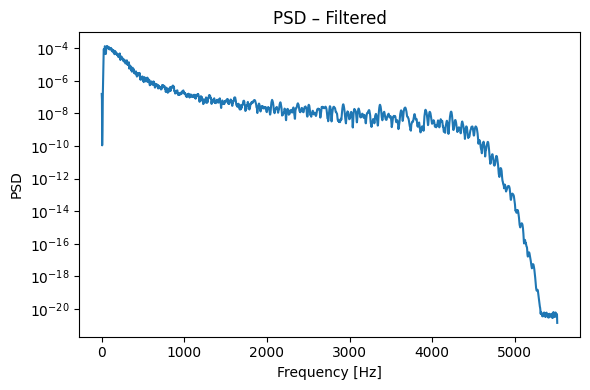

In [9]:
def plot_psd(y, sr, title):
    f, Pxx = welch(y, fs=sr, nperseg=min(4096, len(y)))
    plt.figure(figsize=(6,4))
    plt.semilogy(f, Pxx)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_psd(y_raw, sr_raw, "PSD – Raw")
plot_psd(y_filt, cfg.target_sr, "PSD – Filtered")

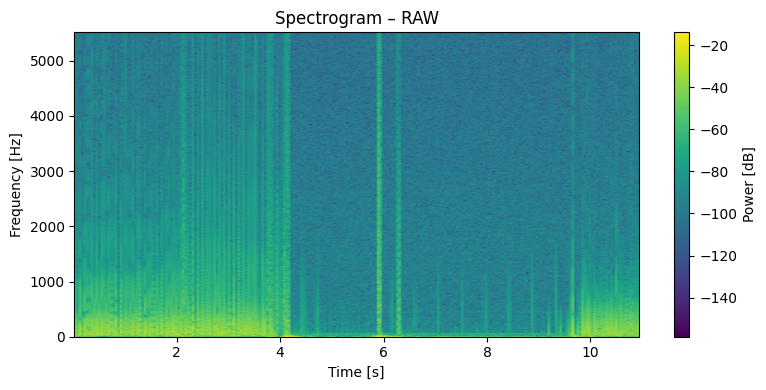

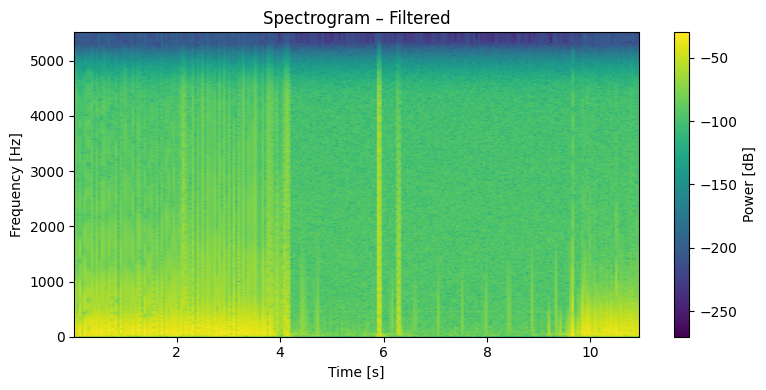

In [10]:

def plot_spectrogram(y, sr, title, nfft=1024, noverlap=512):
    plt.figure(figsize=(8,4))
    plt.specgram(y, NFFT=nfft, Fs=sr, noverlap=noverlap)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title(title)
    plt.colorbar(label="Power [dB]")
    plt.tight_layout()
    plt.show()

plot_spectrogram(y_raw, sr_raw, "Spectrogram – RAW")
plot_spectrogram(y_filt, cfg.target_sr, "Spectrogram – Filtered")

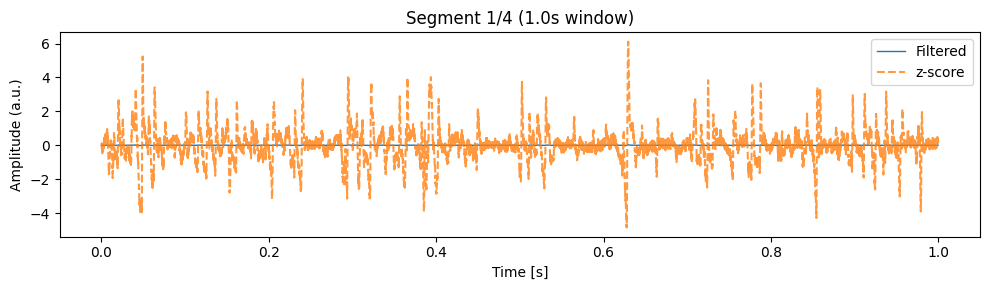

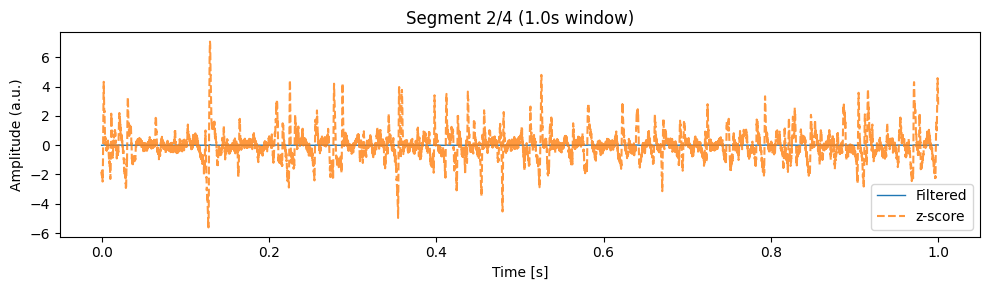

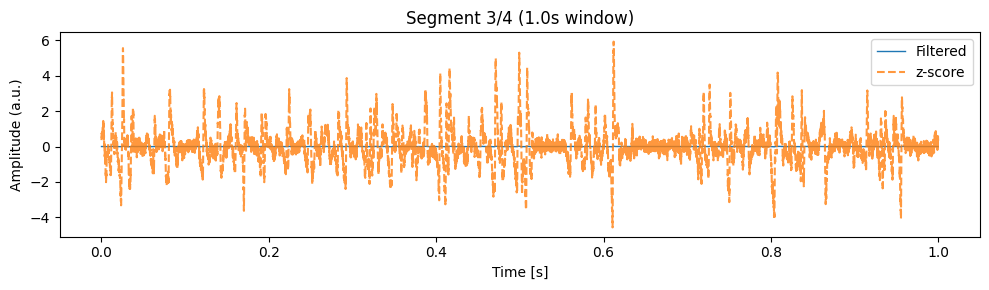

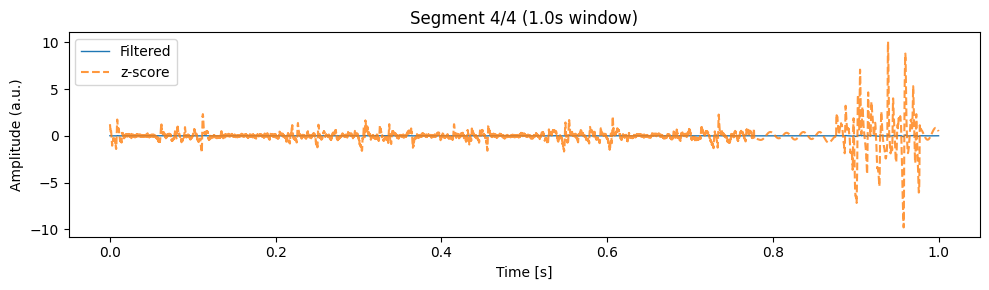

In [ ]:
n_show = min(4, len(segs))
for i in range(n_show):
    t = np.arange(len(segs[i])) / cfg.target_sr
    plt.figure(figsize=(10,3))
    plt.plot(t, segs[i], label="Filtered", linewidth=1)
    plt.plot(t, segs_norm[i], "--", label="z-score", alpha=0.8)
    plt.title(f"Segment {i+1}/{n_show} ({cfg.window_sec}s window)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra

Der Befehl "apt-get" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
